In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os

import torch
import torch.nn as nn

from utils import *
from dataloaders import split_cifar10_100
from approaches import ewc, si, ucl
from networks import conv_net, conv_net_ucl

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

f:\anacoda3\envs\cl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\anacoda3\envs\cl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
split = True
notMNIST = False

# Load data
print('Load data...')
data, taskcla, inputsize = split_cifar10_100.get(seed=42)
print('Input size =', inputsize, '\nTask info =', taskcla)

Load data...
Task order = [9, 2, 6, 1, 8, 3, 10, 5, 4, 7]
Input size = [3, 32, 32] 
Task info = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10)]


## 1. UCL

In [3]:
ucl_args = {
    'experiment': 'split_cifar10_100',
    'approach': 'ucl',
    'beta': 0.0002,  # See the paper for more details
    'ratio': 0.125,
    'alpha': 0.01, # Initialized alpha, when a model is saved then alpha is set to 1,
    'seed': 42,
    'lr': 1e-3,
    'units': 400,
    'batch_size': 256,
    'epochs': 100,
    'optimizer': 'adam',
    'tasknum': 11,
    'parameter': '',
    'conv_net': True
}

log_name = '{}_{}_{}_alpha_{}_beta_{:.5f}_ratio_{:.4f}_lr_{}_units_{}_batch_{}_epoch_{}'.format(
        ucl_args['experiment'], ucl_args['approach'], ucl_args['seed'], ucl_args['alpha'], ucl_args['beta'], ucl_args['ratio'], 
        ucl_args['lr'], ucl_args['units'], ucl_args['batch_size'], ucl_args['epochs'])

ucl_args['output'] = './result_data/' + log_name + '.txt'

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = conv_net_ucl.Net(inputsize, taskcla, ucl_args['ratio']).cuda()
approach = ucl.Approach(net, 
                        ucl_args['epochs'],
                        ucl_args['batch_size'],
                        ucl_args['lr'],
                        args=ucl_args,
                        log_name=log_name,
                        split=split)

print_model_report(net)
print_optimizer_config(approach.optimizer)

In [ ]:
acc = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
loss = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)

for t, ncla in taskcla:
    if t == ucl_args['tasknum']:
        break

    print('*' * 100)
    print('Task {:2d} ({:s})'.format(t, data[t]['name']))
    print('*' * 100)

    # Load data
    X_train = data[t]['train']['X'].cuda()
    y_train = data[t]['train']['y'].cuda()
    X_valid = data[t]['valid']['X'].cuda()
    y_valid = data[t]['valid']['y'].cuda()
    task = t

    # Train
    approach.train(task, X_train, y_train, X_valid, y_valid, data)
    print('-' * 100)

    # Test
    for u in range(t + 1):
        X_test = data[u]['test']['X'].cuda()
        y_test = data[u]['test']['y'].cuda()
        test_loss, test_acc = approach.eval(u, X_test, y_test)
        print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                      100 * test_acc))
        acc[t, u] = test_acc
        loss[t, u] = test_loss

    # Save
    print('Save at ' + ucl_args['output'])
    np.savetxt(ucl_args['output'], acc, fmt='%.4f')
    torch.save(net.state_dict(), './models/trained_model/'+ log_name + '_task_{}.pt'.format(t))

# Done
print('*' * 100)
print('Accuracies =')
for i in range(acc.shape[0]):
    print('\t', end='')
    for j in range(acc.shape[1]):
        print('{:5.1f}% '.format(100 * acc[i, j]), end='')
    print()
print('*' * 100)
print('Done!')



## 2. EWC

In [6]:
ewc_args = {
    'experiment': 'split_cifar10_100',
    'approach': 'ewc',
    'lamb':   25000,
    'seed': 42,
    'lr': 1e-3,
    'units': 400,
    'batch_size': 256,
    'epochs': 100,
    'optimizer': 'adam',
    'tasknum': 11,
    'parameter': '',
    'conv_net': True
}

log_name = '{}_{}_{}_lamb_{}_lr_{}_units_{}_batch_{}_epoch_{}'.format(
        ewc_args['experiment'], ewc_args['approach'], ewc_args['seed'], ewc_args['lamb'],
        ewc_args['lr'], ewc_args['units'], ewc_args['batch_size'], ewc_args['epochs'])

ewc_args['output'] = './result_data/' + log_name + '.txt'

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = conv_net.Net(inputsize, taskcla).cuda()
approach = ewc.Approach(net, 
                        ewc_args['epochs'],
                        ewc_args['batch_size'],
                        ewc_args['lr'],
                        args=ewc_args,
                        log_name=log_name,
                        split=split)

print_model_report(net)
print_optimizer_config(approach.optimizer)

In [ ]:
acc = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
loss = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)

for t, ncla in taskcla:
    if t == ewc_args['tasknum']:
        break

    print('*' * 100)
    print('Task {:2d} ({:s})'.format(t, data[t]['name']))
    print('*' * 100)

    # Load data
    X_train = data[t]['train']['X'].cuda()
    y_train = data[t]['train']['y'].cuda()
    X_valid = data[t]['valid']['X'].cuda()
    y_valid = data[t]['valid']['y'].cuda()
    task = t

    # Train
    approach.train(task, X_train, y_train, X_valid, y_valid, data)
    print('-' * 100)

    # Test
    for u in range(t + 1):
        X_test = data[u]['test']['X'].cuda()
        y_test = data[u]['test']['y'].cuda()
        test_loss, test_acc = approach.eval(u, X_test, y_test)
        print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                      100 * test_acc))
        acc[t, u] = test_acc
        loss[t, u] = test_loss

    # Save
    print('Save at ' + ewc_args['output'])
    np.savetxt(ewc_args['output'], acc, fmt='%.4f')
    torch.save(net.state_dict(), './models/trained_model/'+ log_name + '_task_{}.pt'.format(t))

# Done
print('*' * 100)
print('Accuracies =')
for i in range(acc.shape[0]):
    print('\t', end='')
    for j in range(acc.shape[1]):
        print('{:5.1f}% '.format(100 * acc[i, j]), end='')
    print()
print('*' * 100)
print('Done!')



## 3. SI

In [9]:
si_args = {
    'experiment': 'split_cifar10_100',
    'approach': 'si',
    'c': 0.7,
    'seed': 42,
    'lr': 1e-3,
    'units': 400,
    'batch_size': 256,
    'epochs': 100,
    'optimizer': 'adam',
    'tasknum': 11,
    'parameter': '',
    'conv_net': True
}

log_name = '{}_{}_{}_c_{}_lr_{}_units_{}_batch_{}_epoch_{}'.format(
        si_args['experiment'], si_args['approach'], si_args['seed'], si_args['c'],
        si_args['lr'], si_args['units'], si_args['batch_size'], si_args['epochs'])

si_args['output'] = './result_data/' + log_name + '.txt'

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = conv_net.Net(inputsize, taskcla).cuda()
approach = si.Approach(net, 
                       si_args['epochs'],
                       si_args['batch_size'],
                       si_args['lr'],
                       args=si_args,
                       log_name=log_name,
                       split=split)

print_model_report(net)
print_optimizer_config(approach.optimizer)

In [ ]:
acc = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
loss = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)

for t, ncla in taskcla:
    if t == si_args['tasknum']:
        break

    print('*' * 100)
    print('Task {:2d} ({:s})'.format(t, data[t]['name']))
    print('*' * 100)

    # Load data
    X_train = data[t]['train']['X'].cuda()
    y_train = data[t]['train']['y'].cuda()
    X_valid = data[t]['valid']['X'].cuda()
    y_valid = data[t]['valid']['y'].cuda()
    task = t

    # Train
    approach.train(task, X_train, y_train, X_valid, y_valid, data)
    print('-' * 100)

    # Test
    for u in range(t + 1):
        X_test = data[u]['test']['X'].cuda()
        y_test = data[u]['test']['y'].cuda()
        test_loss, test_acc = approach.eval(u, X_test, y_test)
        print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                      100 * test_acc))
        acc[t, u] = test_acc
        loss[t, u] = test_loss

    # Save
    print('Save at ' + si_args['output'])
    np.savetxt(si_args['output'], acc, fmt='%.4f')
    torch.save(net.state_dict(), './models/trained_model/'+ log_name + '_task_{}.pt'.format(t))

# Done
print('*' * 100)
print('Accuracies =')
for i in range(acc.shape[0]):
    print('\t', end='')
    for j in range(acc.shape[1]):
        print('{:5.1f}% '.format(100 * acc[i, j]), end='')
    print()
print('*' * 100)
print('Done!')



## Result

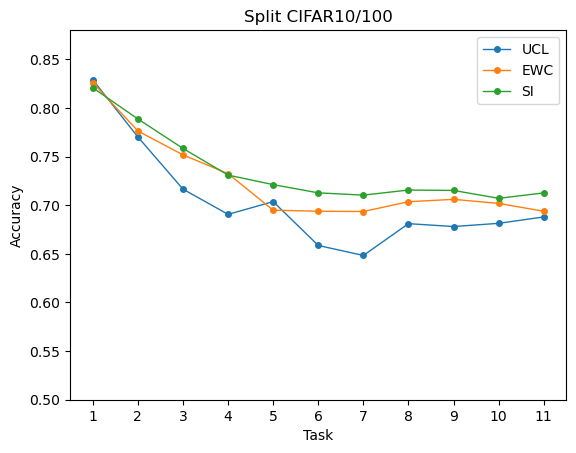

In [4]:
# Load results
acc_ucl = np.loadtxt('./result_data/split_cifar10_100_ucl_42_alpha_0.01_beta_0.00020_ratio_0.1250_lr_0.001_units_400_batch_256_epoch_100.txt')
acc_ewc = np.loadtxt('./result_data/split_cifar10_100_ewc_42_lamb_25000_lr_0.001_units_400_batch_256_epoch_100.txt')
acc_si = np.loadtxt('./result_data/split_cifar10_100_si_42_c_0.7_lr_0.001_units_400_batch_256_epoch_100.txt')

tasks = np.arange(1, 12)

plt.plot(tasks, acc_ucl.sum(axis=1) / tasks, '-o', label='UCL', lw=1, markersize=4)
plt.plot(tasks, acc_ewc.sum(axis=1) / tasks, '-o', label='EWC', lw=1, markersize=4)
plt.plot(tasks, acc_si.sum(axis=1) / tasks, '-o', label='SI', lw=1, markersize=4)

plt.title('Split CIFAR10/100')
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.ylim(0.50, 0.88)
plt.legend()
plt.show()

__Note__
- The main difference here is that I use optimizer from pytorch. In the paper they re-implement the optimizer from scratch with addtional rho parameters that makes the optimizer more stable. I will try to implement it later.